## 1. Загрузка библиотек и данных

In [1]:
import pandas as pd # работа с датафреймами
import numpy as np # векторная алгебра

from scipy import stats # тесты

import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # тоже для визуализации, надстройка над предыдущим

from sklearn import preprocessing  # предобработка данных
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV # линейные модели

from sklearn.ensemble import RandomForestClassifier # случайный лес

# Градиентный бустинг
from catboost import CatBoostClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.neighbors import KNeighborsClassifier # K-ближайших соседей

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split # для кроссвалидация

from sklearn.metrics import roc_auc_score, f1_score, recall_score # метрики

from sklearn.calibration import CalibratedClassifierCV # для калибровки вероятностей

from sklearn.utils.class_weight import compute_class_weight

from typing import List

pd.set_option('display.max_columns', None) # параметр, настраивающий видимое число столбцов в Юпитер-ноутбуке

In [2]:
TRAIN_FILENAME = 'data/train_dataset_train.csv'
TEST_FILENAME = 'data/test_dataset_test.csv'

In [3]:
train_dataset = pd.read_csv(TRAIN_FILENAME)

test_dataset = pd.read_csv(TEST_FILENAME)

In [4]:
train_dataset = train_dataset.set_index('id')
test_dataset = test_dataset.set_index('id')

In [5]:
train_dataset.shape, test_dataset.shape

((4222094, 5), (1809469, 4))

## 2. Исследование данных

In [6]:
train_dataset.describe()

,Easting,Northing,Height,Reflectance,Class
count,4.222094e+06,4.222094e+06,4.222094e+06,4.222094e+06,4.222094e+06
mean,4.317068e+05,6.032308e+06,6.940159e+01,-1.053063e+01,1.155633e+00
std,2.977279e+01,2.981495e+01,2.269884e+00,4.515277e+00,2.535087e+00
min,4.316294e+05,6.032232e+06,6.041440e+01,-3.796000e+01,0.000000e+00
25%,4.316825e+05,6.032284e+06,6.779070e+01,-1.263000e+01,0.000000e+00
50%,4.317069e+05,6.032307e+06,6.920490e+01,-9.940000e+00,0.000000e+00
75%,4.317308e+05,6.032332e+06,6.929940e+01,-7.730000e+00,3.000000e+00
max,4.317812e+05,6.032384e+06,1.337185e+02,4.360000e+00,6.400000e+01


In [7]:
# Считаем пропущенные значения для обучающей выборки -> таких нет
na_count = train_dataset.isna().sum()
na_count[na_count > 0]

Series([], dtype: int64)

In [8]:
# Считаем пропущенные значения для тестовой выборки -> таких нет
na_count = test_dataset.isna().sum()
na_count[na_count > 0]

Series([], dtype: int64)

#### Распределение данных

Text(0.5, 1.0, 'Распределение классов точек')

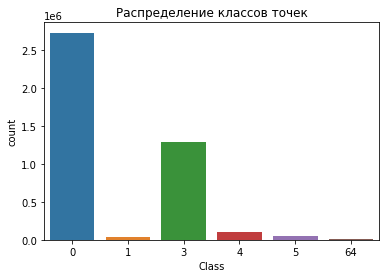

In [9]:
sns.countplot(x = "Class" , data  = train_dataset).set_title('Распределение классов точек')

## Построение обучающей выборки

In [10]:
# Количество экземпляров каждого класса
train_dataset['Class'].value_counts() 

0     2731040
3     1287816
4      103453
5       55985
1       39384
64       4416
Name: Class, dtype: int64

In [11]:
# Балансировка классов - из классов с очень большим числом объектов (0, 3, 4) берем 
# заранее установленное количество экземпляров (по количеству элементов класса 5)
N_SAMPLES = len(train_dataset[train_dataset['Class']==5].index) #55985
data_train = pd.concat([train_dataset[train_dataset['Class']==0].sample(n=N_SAMPLES, random_state=1),
                       train_dataset[train_dataset['Class']==1],
                       train_dataset[train_dataset['Class']==3].sample(n=N_SAMPLES, random_state=1),
                       train_dataset[train_dataset['Class']==4].sample(n=N_SAMPLES, random_state=1),
                       train_dataset[train_dataset['Class']==5],
                       train_dataset[train_dataset['Class']==64]])


In [12]:
data_train.shape

(267740, 5)

In [13]:
data_train['Class'].value_counts() 

5     55985
4     55985
3     55985
0     55985
1     39384
64     4416
Name: Class, dtype: int64

In [14]:
data_train['Class']

id
1532209     0
3367549     0
5437361     0
1034235     0
5914838     0
           ..
5063393    64
3147680    64
4838531    64
3463867    64
2487027    64
Name: Class, Length: 267740, dtype: int64

Text(0.5, 1.0, 'Распределение классов точек')

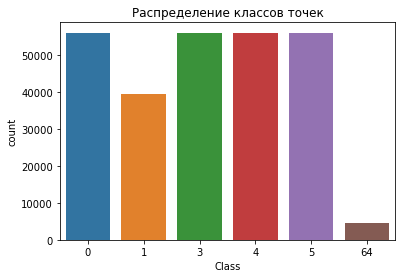

In [15]:
# Распределение классов на новой обучающей выборке
sns.countplot(x = "Class" , data  = data_train).set_title('Распределение классов точек')

#### Feature_engineering

In [16]:
def feature_engineering(df:  pd.DataFrame) ->  pd.DataFrame:
    """Добавление новых признаков в датафрейм."""
    
    # Добавляем диагонали проекций на плоскости, диагональ параллелепипеда, суммы преокций по X и Y,
    # углол между диагональю проекции на XOY и осью X
    new_df = df.copy()
    new_df['Diagonal_x_y'] = np.sqrt(new_df['Northing']**2 + new_df['Easting']**2)
    new_df['Diagonal_y_z'] = np.sqrt(new_df['Northing']**2 + new_df['Height']**2)
    new_df['Diagonal_x_z'] = np.sqrt(new_df['Height']**2 + new_df['Easting']**2)
    new_df['Diagonal'] = np.sqrt(new_df['Diagonal_x_y']**2 + new_df['Height']**2)
    new_df['Easting+Northing'] = new_df['Easting']+new_df['Northing'] 
    new_df['sqrt(Easting)+sqrt(Northing)'] = np.sqrt(new_df['Easting']) + np.sqrt(new_df['Northing'])
    new_df['Alpha'] = np.arctan(new_df['Northing'] / new_df['Easting'])
    new_df['Is_Reflectance_round'] = (new_df['Reflectance'] % 10 == 0)
    
    return new_df

In [17]:
# Добавление новых признаков
target = data_train['Class']
data_train = data_train.drop('Class', axis=1)
data_train = feature_engineering(data_train)

## Построение модели

In [18]:
X = data_train.values
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [19]:
# CatBoostClassifier
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

model_catboost =  CatBoostClassifier(class_weights=class_weights)
model_catboost.fit(X_train, y_train, verbose=False, plot=False)
pred_catboost = model_catboost.predict(X_test)
result = recall_score(y_test, pred_catboost, average='macro', zero_division=True)

print("Recall score",result) 

Recall score 0.9707851314265833


In [20]:
# RandomForestClassifier
rf_model = RandomForestClassifier(n_jobs=-1, max_depth=100)
rf_model.fit(X_train, y_train)
pred_forest = rf_model.predict(X_test)
result = recall_score(y_test, pred_forest, average='macro', zero_division=True)

print("Recall score",result) 

Recall score 0.9621749947838124


In [21]:
# XGBClassifier
y_train_code = list(map(lambda x: 2 if x==64 else x, y_train))
model =  XGBClassifier(reg_alpha=0.05, reg_lambda=0.05, n_jobs=-1)
model.fit(X_train, y_train_code)
pred_xgb = model.predict(X_test)
pred_xgb = list(map(lambda x: 64 if x==2 else x, pred_xgb))
result = recall_score(y_test, pred_xgb, average='macro', zero_division=True)

print("Recall score",result) 

Recall score 0.96239742813658


In [22]:
# KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=4, n_jobs=-1, weights='distance')
model.fit(X_train, y_train)
pred_kneigh = model.predict(X_test)
result = recall_score(y_test, pred_kneigh, average='macro', zero_division=True)

print("Recall score",result) 

Recall score 0.912668518504763


In [23]:
# LogisticRegression
scal = preprocessing.StandardScaler()
X_train_norm = scal.fit_transform(X_train)
X_test_norm = scal.transform(X_test)

model = LogisticRegression(penalty='l2', 
                            n_jobs=-1,
                            multi_class='multinomial',
                            class_weight='balanced')
model.fit(X_train_norm, y_train)
pred_log = model.predict(X_test_norm)
result = recall_score(y_test, pred_log, average='macro', zero_division=True)

print("Recall score",result) 

Recall score 0.785341769427688


In [24]:
# LGBMClassifier
model =  LGBMClassifier(n_jobs=-1,
                      objective='multiclass',
                      class_weight=class_weights 
                      )
model.fit(X_train, y_train)
pred_lgbm = model.predict(X_test)
result = recall_score(y_test, pred_lgbm, average='macro', zero_division=True)

print("Recall score",result) 

Recall score 0.9740115832257553


#### Были отобраны три лучшие модели - CatBoost, XGBoost, LightGBM. Оценка усредненных предсказаний трех моделей

In [25]:
res = pd.DataFrame({'catboost': pred_catboost.reshape(-1),
                    'xgb': pred_xgb,
                    'lgbm': pred_lgbm})

In [26]:
pred = stats.mode(res, axis=1, keepdims=False)[0]

In [27]:
# CatBoost, XGBoost, LightGBM
result = recall_score(y_test, pred, average='macro', zero_division=True)

print("Recall score",result)

Recall score 0.9730947454721655


## Обучение на всей выборке и предсказание на тестовой

In [28]:
class EnsembleBoostClassifier(object):
    """Классификатор, реализуюший ансамблевый алгоритм,
    основанный на трех разных реализациях градиентного бустинга:
    CatBoost, XGBoost, LightGBM"""
    
    def __init__(self, class_weights=None):
        self.catboost = CatBoostClassifier(class_weights=class_weights)
        self.xgb = XGBClassifier(reg_alpha=0.05, reg_lambda=0.05, n_jobs=-1)
        self.lgbm = LGBMClassifier(n_jobs=-1,
                      objective='multiclass',
                      class_weight=class_weights)
    
    def fit(self, X, y):
        self.catboost.fit(X, y, verbose=False, plot=False)
        self.lgbm.fit(X, y)
        
        self.le = preprocessing.LabelEncoder()
        y_encode = self.le.fit_transform(y)
        self.xgb.fit(X, y_encode)
        
    def predict(self, X):
        pred_catboost = self.catboost.predict(X).reshape(-1)
        pred_lgbm = self.lgbm.predict(X)
        
        pred_xgb = self.xgb.predict(X)
        pred_xgb = self.le.inverse_transform(pred_xgb)
        
        pred_agg = np.transpose([pred_catboost, pred_lgbm, pred_xgb])
        pred = stats.mode(pred_agg, axis=1, keepdims=False)[0]
        
        return pred

In [29]:
# Обработка тестовой выборки
data_test = feature_engineering(test_dataset)

In [30]:
ensemble_clf = EnsembleBoostClassifier(class_weights=class_weights)
ensemble_clf.fit(X, y)
pred_test = ensemble_clf.predict(data_test.values)
res = pd.DataFrame({'id': data_test.index, 'Class': pred_test})
res.to_csv('Solution_4.csv', index=False)